# Hack tha Cart 2022

[Введение](#beginning)

1. [Загрузка и предобработка данных](#preprocessing)

2. [Моделирование](#modelling)
 
3. [Общий вывод](#summary)  

##Введение

В ходе данной работы будет разработана система рекомендаций для пользователя по текущей корзине в приложении "Лента Онлайн", которая позволит клиентам не забыть положить в корзину все необходимое и сократить время на шопинг, а “Ленте” – увеличить прибыль интернет-магазина.

Будут использованы следующие данные:

hist_data.csv - исторические данные о покупках
- buyer_id - id покупателя
- pav_order_id - id заказа
- created - время добавления в заказ
- item_id - id item'а
- count - количество выбранного товара в заказе
- price_sold - цена за 1 item
- flag_weight_goods - бинарный флаг того, является ли товар весовым
- weight - вес заказа

test.csv - текущее состояние корзины (последний заказ пользователя)
- buyer_id - id покупателя
- pav_order_id - id заказа
- created - время добавления в заказ
- item_id - id item'а (товара)
- count - количество выбранного товара в заказе
- price_sold - цена за 1 item
- flag_weight_goods - бинарный флаг того, является ли товар весовым

**Выводы**

В ходе работы были испробованы разные подходы (коллаборативной фильтрации, использования дней недели в качестве фичи для выявления популярных в этот день товаров), но они не дали высокого скора:

В результате был выбран наиболее успешный вариант - гибридной рекомендательной системы, остальные попытки из работы удалены.

*  для заполнения рекомендаций пользователям с историей покупок был использован user-based подход: словарь самых частых для них item_id, расширенный для пользователей с малым количеством покупок до самых популярных в целом товаров;
*   для заполнения рекомендаций пользователям без истории покупок использован статистический подход: словарь совстречаемости покупок товаров. 


<a id="preprocessing"></a>
## Загрузка и предобработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import gc

from collections import Counter 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
path = '/content/gdrive/MyDrive/dls/hist_data.csv'

In [4]:
hist_data = pd.read_csv(path)

In [5]:
path2 = '/content/gdrive/MyDrive/dls/test.csv'

In [6]:
test = pd.read_csv(path2, parse_dates=['created'])

In [7]:
path3 = '/content/gdrive/MyDrive/dls/sample_submission.csv'

In [8]:
sample_submission = pd.read_csv(path3)

In [9]:
hist_data.tail()

,buyer_id,pav_order_id,created,item_id,count,price_sold,flag_weight_goods,weight
4529884,95619205,4620221347,2021-09-07 18:48:29,204351817,1.000,99.990,False,9.840
4529885,95619205,4620221347,2021-09-07 18:48:29,203523604,1.000,62.190,False,9.840
4529886,95619205,4620221347,2021-09-07 18:48:29,203566357,2.000,39.890,False,9.840
4529887,95619205,4620221347,2021-09-07 18:48:29,203566418,1.000,62.190,False,9.840
4529888,95619205,4620221347,2021-09-07 18:48:29,204351820,1.000,99.990,False,9.840


In [10]:
hist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4529889 entries, 0 to 4529888
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   buyer_id           int64  
 1   pav_order_id       int64  
 2   created            object 
 3   item_id            int64  
 4   count              float64
 5   price_sold         float64
 6   flag_weight_goods  bool   
 7   weight             float64
dtypes: bool(1), float64(3), int64(3), object(1)
memory usage: 246.2+ MB


In [11]:
hist_data['created'] = pd.to_datetime(hist_data['created'], format='%Y-%m-%dT%H:%M:%S')

In [12]:
hist_data['created'].min()


Timestamp('2021-07-01 00:03:44')

In [13]:
hist_data['created'].max()

Timestamp('2021-09-07 18:48:29')

In [14]:
hist_data.describe()

,buyer_id,pav_order_id,item_id,count,price_sold,weight
count,4529889.000,4529889.000,4529889.000,4529889.000,4529882.000,4529889.000
mean,95260181.303,95511886865.660,203651442.928,1.453,104.644,18.137
std,472959.365,16496245337.305,1624362.141,1.527,705.227,10.765
min,94578442.000,4620121471.000,202782406.000,0.001,0.000,0.000
25%,94839624.000,98509589146.000,202838754.000,1.000,44.690,10.660
50%,95168703.000,98512719743.000,203367252.000,1.000,69.990,15.710
75%,95623575.000,98515778223.000,203566436.000,1.488,121.447,22.660
max,96400990.000,98521253887.000,218240709.000,600.000,749850.000,221.530


Соберем словарь встречаемостей - какие item_id покупались чаще с каждым item_id

In [15]:
tmp = (
    hist_data[['item_id', 'pav_order_id']]
    .sort_values(['item_id', 'pav_order_id'])
    .merge(hist_data[['item_id', 'pav_order_id']], how='left', on=['pav_order_id'], suffixes=('', '_left'))
)
tmp = tmp[tmp['item_id'] != tmp['item_id_left']].copy()
tmp1 = tmp.groupby(['item_id'])['item_id_left'].agg(lambda x: Counter(x).most_common(10))

most_freq_dict = {k: v for (k, v) in tmp1.iteritems()}

del tmp1, tmp
gc.collect()

0

Из списка кандидатов по совстречаемости удаляем повторяющиеся item_id, сохраняя порядок

In [16]:
def get_unique_recs(recs: list, top_n: int) -> list:
    rec_dict = {}
    counter = 0
    for k, v in recs:
        if k not in rec_dict:
            rec_dict[k] = v
            counter += 1
        if counter == top_n:
            break
    return list(rec_dict.keys())

def rec_by_item(item_id: int, most_freq_dict: dict) -> list:
    
    return most_freq_dict.get(item_id, None)


In [17]:
hist_data.sort_values(by="price_sold", ascending = False).head()

,buyer_id,pav_order_id,created,item_id,count,price_sold,flag_weight_goods,weight
505098,94950058,98508150998,2021-07-07 17:06:25,203370019,4.650,749850.000,True,9.840
961245,94887683,98509435613,2021-07-13 17:11:47,203370019,5.944,674850.000,True,24.910
963478,95104279,98509441602,2021-07-13 17:38:53,203370019,5.274,674850.000,True,30.170
805627,95983934,98508989003,2021-07-11 14:18:29,203370019,4.570,599850.000,True,15.160
889171,95225942,98509227439,2021-07-12 16:53:33,203370019,4.990,599850.000,True,8.090


Произведём очистку данных: удалим товары с ценой более 5000 руб. за единицу и купленные в количестве более 200 единиц (в основном, это выбросы. Но даже невыбросы с такой высокой ценой рекомендовать не имеет смысла). А также удалим дубликаты строк.

In [18]:
hist_data_cleaned = hist_data.query('price_sold < 5000 and 0.1 <= count <= 202').drop_duplicates()

In [19]:
hist_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4528852 entries, 0 to 4529888
Data columns (total 8 columns):
 #   Column             Dtype         
---  ------             -----         
 0   buyer_id           int64         
 1   pav_order_id       int64         
 2   created            datetime64[ns]
 3   item_id            int64         
 4   count              float64       
 5   price_sold         float64       
 6   flag_weight_goods  bool          
 7   weight             float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int64(3)
memory usage: 280.7 MB


In [20]:
hist_data_cleaned.sort_values(by="count", ascending = True).head()

,buyer_id,pav_order_id,created,item_id,count,price_sold,flag_weight_goods,weight
3445858,96097560,98516071887,2021-08-16 09:56:51,203092693,0.100,39.900,True,31.490
528257,95723916,98508242204,2021-07-08 08:29:58,203092693,0.100,87.439,True,8.760
287119,94818845,98507475615,2021-07-04 15:40:28,203092693,0.100,64.999,True,13.410
3397732,95239314,98515928040,2021-08-15 13:29:07,202993712,0.100,64.998,True,21.060
3347405,96227678,98515791499,2021-08-14 18:05:42,203075450,0.100,119.900,True,9.160


<a id="modelling"></a>
## Моделирование

Рассчитаем количество заказанных товаров в заказах по пользователям

In [21]:
pivot_orders_per_user = hist_data_cleaned.pivot_table(index=['buyer_id', 'pav_order_id'], values=['price_sold'], aggfunc=['count'])
pivot_orders_per_user.columns = ['number_of_items_in_order']
pivot_orders_per_user = pivot_orders_per_user.sort_values(by = ['number_of_items_in_order'], ascending = False)
pivot_orders_per_user = pivot_orders_per_user.reset_index()
pivot_orders_per_user.head()

,buyer_id,pav_order_id,number_of_items_in_order
0,95357441,98508735601,132
1,95645328,98515078436,129
2,94669982,98506886492,124
3,94721255,98515705471,122
4,94801698,98513293809,121


In [22]:
pivot_number_of_orders = pivot_orders_per_user.pivot_table(index=['buyer_id'], values=['pav_order_id'], aggfunc=['count'])
pivot_number_of_orders.columns = ['number_of_orderd']
pivot_number_of_orders = pivot_number_of_orders.sort_values(by = ['number_of_orderd'], ascending = False)
pivot_number_of_orders = pivot_number_of_orders.reset_index()
pivot_number_of_orders.head()

,buyer_id,number_of_orderd
0,95694980,19
1,96075453,19
2,95099776,19
3,96166342,19
4,95355948,19


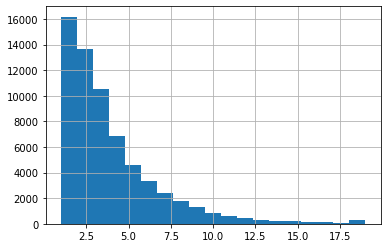

In [23]:
pivot_number_of_orders['number_of_orderd'].hist(bins = 19);

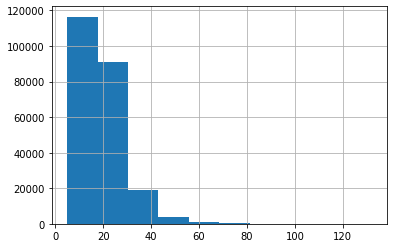

In [24]:
pivot_orders_per_user['number_of_items_in_order'].hist();

Подготовим данные для словаря покупок по пользователям в порядке убывания количества заказов item_id.

In [25]:
pivot_users = hist_data_cleaned.pivot_table(index=['buyer_id', 'item_id'], values=['count'], aggfunc=['count'])
pivot_users.columns = ['frec']
pivot_users = pivot_users.sort_values(by = ['buyer_id', 'frec'], ascending = False)
pivot_users = pivot_users.reset_index()
pivot_users.sample(10)

,buyer_id,item_id,frec
713587,95765881,203370019,1
3064984,94752978,203059303,1
2292219,95023100,202991992,1
3439448,94649425,202807187,1
495894,95932549,204043025,1
2462942,94955989,216402193,1
285708,96062894,203276809,1
1826038,95176259,203402007,1
1513707,95301459,204364604,1
1364390,95370429,203441316,1


In [26]:
frequent_ids_pivot_users = pivot_users.query('frec > 0')

In [27]:
frequent_ids_pivot_users

,buyer_id,item_id,frec
0,96400990,202793061,1
1,96400990,202808690,1
2,96400990,202927858,1
3,96400990,202997964,1
4,96400990,203029021,1
...,...,...,...
3643383,94578442,204103777,1
3643384,94578442,205810829,1
3643385,94578442,205913777,1
3643386,94578442,207194697,1


In [28]:
frequent_ids_pivot_users = frequent_ids_pivot_users.sort_values(by = ['buyer_id', 'frec'], ascending = False)

In [29]:
frequent_ids_pivot_users

,buyer_id,item_id,frec
0,96400990,202793061,1
1,96400990,202808690,1
2,96400990,202927858,1
3,96400990,202997964,1
4,96400990,203029021,1
...,...,...,...
3643383,94578442,204103777,1
3643384,94578442,205810829,1
3643385,94578442,205913777,1
3643386,94578442,207194697,1


In [30]:
freq_it_per_user = frequent_ids_pivot_users.groupby(['buyer_id'])['item_id'].agg([(list)])

In [31]:
freq_it_per_user.columns = ['items_ordered']
freq_it_per_user = freq_it_per_user.reset_index()

In [32]:
freq_it_per_user

,buyer_id,items_ordered
0,94578442,"[202801709, 202806979, 202979560, 203438161, 2..."
1,94578475,"[202791192, 202791620, 202807187, 202808408, 2..."
2,94578533,"[202807066, 202807401, 202809628, 202864758, 2..."
3,94578595,"[202799674, 202801849, 202806977, 202807477, 2..."
4,94578656,"[202838754, 202872237, 202807411, 202820148, 2..."
...,...,...
63920,96395136,"[202793061, 202799842, 202801739, 202807180, 2..."
63921,96397556,"[202806879, 202806882, 202806999, 202807205, 2..."
63922,96399270,"[202793061, 202806890, 202807467, 202820468, 2..."
63923,96399769,"[202793169, 202798244, 202808207, 202963771, 2..."


Cоберём список самых часто встречающихся покупок в целом.

In [33]:
top_items = hist_data_cleaned.pivot_table(index=['item_id'], values=['count'], aggfunc=['count'])
top_items.columns = ['number_of_items_sold']
top_items = top_items.sort_values(by = ['number_of_items_sold'], ascending = False)
top_items = top_items.reset_index()
top_items = top_items.head(50)

In [34]:
top_items_list = top_items['item_id'].tolist()

Расширим список покупок для каждого пользователя списком самых часто покупаемых товаров, чтобы не было пользователей, у которых в списке было бы менее 20 видов товаров.

In [35]:
for i in range(63925):
    freq_it_per_user['items_ordered'][i].extend(top_items_list)

In [36]:
freq_it_per_user

,buyer_id,items_ordered
0,94578442,"[202801709, 202806979, 202979560, 203438161, 2..."
1,94578475,"[202791192, 202791620, 202807187, 202808408, 2..."
2,94578533,"[202807066, 202807401, 202809628, 202864758, 2..."
3,94578595,"[202799674, 202801849, 202806977, 202807477, 2..."
4,94578656,"[202838754, 202872237, 202807411, 202820148, 2..."
...,...,...
63920,96395136,"[202793061, 202799842, 202801739, 202807180, 2..."
63921,96397556,"[202806879, 202806882, 202806999, 202807205, 2..."
63922,96399270,"[202793061, 202806890, 202807467, 202820468, 2..."
63923,96399769,"[202793169, 202798244, 202808207, 202963771, 2..."


ИЗ подготовленных данных создадим словарь часто покупаемых товаров по каждому пользователю.

In [37]:
tmp_items_per_users = hist_data_cleaned.groupby(['buyer_id'])['item_id'].agg(lambda x: Counter(x).most_common(30))

In [38]:
buyer_ids = list(freq_it_per_user['buyer_id'])
items_ordered = list(freq_it_per_user['items_ordered'])

In [39]:
most_freq_items_per_users ={}

Получили словарь самых часто встречающихся покупок для каждого пользователя с добавленными просто самыми топ-часто покупаемыми товарами.

In [40]:
most_freq_items_per_users = {}
for i in range(len(items_ordered)):
    most_freq_items_per_users[buyer_ids[i]] = items_ordered[i]

Продолжим работу по подсчёту совстречаемости покупок товаров:
Для каждого item_id соберем top_n самых часто встречающихся item_id,  отсортируем по частоте и выберем уникальные.
Этот словарь будет использован в дальнейшем для заполнения рекомендаций пользователям без истории покупок.

In [41]:
def rec_by_basket(basket: list, most_freq_dict: dict, top_n: int = 20) -> list:
    
    res = []
    for item in basket:
        recs = rec_by_item(item, most_freq_dict)
        if recs is not None:
            res += recs
    
    res = sorted(res, key=lambda x: x[1], reverse=True)
    
    return get_unique_recs(res, top_n)

In [42]:
pred = test.groupby(['pav_order_id'])['item_id'].agg([('basket', list)])

In [43]:
pred['preds'] = pred['basket'].map(lambda x: rec_by_basket(x, most_freq_dict=most_freq_dict))

In [44]:
pred = pred.reset_index()

In [45]:
pred

,pav_order_id,basket,preds
0,4620121489,"[203164283, 204043498, 204146308, 204119602, 2...","[202820148, 202872237, 202791620, 202809628, 2..."
1,4620121505,"[202819114, 204074914, 202822471, 202880254, 2...","[202820148, 202872237, 202880262, 203068900, 2..."
2,4620121594,"[202818687, 203430473, 204016498, 203017711, 2...","[202820148, 202872237, 203059303, 202809628, 2..."
3,4620121684,"[203338264, 203436378, 203433668, 202812161, 2...","[202820148, 202872237, 203090014, 203090010, 2..."
4,4620121902,"[205768202, 202811971, 203429467, 204393593, 2...","[202820148, 203422957, 203431923, 202872237, 2..."
...,...,...,...
80239,98521278256,"[203428006, 202856200, 203406593, 203390294, 2...","[202820148, 202791192, 202872237, 202809628, 2..."
80240,98521278378,"[202966002, 204090577, 203403030, 204113387, 2...","[202820148, 202872237, 202809628, 203370019, 2..."
80241,98521278699,"[202808263, 203473696, 203476300, 203497376, 2...","[202820148, 202872237, 202809628, 203529288, 2..."
80242,98521278890,"[203499550, 202820398, 202991954, 203499548, 2...","[202872237, 202809628, 202838754, 203059303, 2..."


In [46]:
pav_ids = list(pred['pav_order_id'])
baseline_preds = list(pred['preds'])
baseline_dict_preds ={}
for i in range(len(pav_ids)):
    baseline_dict_preds[pav_ids[i]] = baseline_preds[i]

Сгруппируем тестовые данные по пользователям и уникальным заказам

In [47]:
test_cleaned = test.pivot_table(index=['buyer_id', 'pav_order_id'], values=['item_id'], aggfunc=['count'])
test_cleaned.columns = ['items_in_order']
test_cleaned = test_cleaned.reset_index()
test_cleaned.sample(5)

,buyer_id,pav_order_id,items_in_order
6238,94683961,98520610674,17
62985,95871123,98519341748,8
76495,96278372,98517325741,8
15915,94819787,98518461471,32
64344,95922947,98516833551,9


In [48]:
test_ids = test.groupby(['pav_order_id', 'buyer_id'])['item_id'].agg([(list)])

In [49]:
test_ids.columns = ['list_of_items_bought']
test_ids = test_ids.reset_index()

In [50]:
test_ids

,pav_order_id,buyer_id,list_of_items_bought
0,4620121489,95969605,"[203164283, 204043498, 204146308, 204119602, 2..."
1,4620121505,95823859,"[202819114, 204074914, 202822471, 202880254, 2..."
2,4620121594,95487550,"[202818687, 203430473, 204016498, 203017711, 2..."
3,4620121684,95970193,"[203338264, 203436378, 203433668, 202812161, 2..."
4,4620121902,95803805,"[205768202, 202811971, 203429467, 204393593, 2..."
...,...,...,...
80239,98521278256,94762690,"[203428006, 202856200, 203406593, 203390294, 2..."
80240,98521278378,95288263,"[202966002, 204090577, 203403030, 204113387, 2..."
80241,98521278699,94747517,"[202808263, 203473696, 203476300, 203497376, 2..."
80242,98521278890,96253660,"[203499550, 202820398, 202991954, 203499548, 2..."


In [51]:
test_ids['preds'] = list

In [52]:
for i in range(80244):
    test_ids['preds'][i] = []

In [53]:
freq_it_per_user

,buyer_id,items_ordered
0,94578442,"[202801709, 202806979, 202979560, 203438161, 2..."
1,94578475,"[202791192, 202791620, 202807187, 202808408, 2..."
2,94578533,"[202807066, 202807401, 202809628, 202864758, 2..."
3,94578595,"[202799674, 202801849, 202806977, 202807477, 2..."
4,94578656,"[202838754, 202872237, 202807411, 202820148, 2..."
...,...,...
63920,96395136,"[202793061, 202799842, 202801739, 202807180, 2..."
63921,96397556,"[202806879, 202806882, 202806999, 202807205, 2..."
63922,96399270,"[202793061, 202806890, 202807467, 202820468, 2..."
63923,96399769,"[202793169, 202798244, 202808207, 202963771, 2..."


Создадим рекомендации:

*   для заполнения рекомендаций пользователям с историей покупок используем словарь самых частых для них item_id, расширенный до самых популярных в целом товаров для пользователей с малым количеством покупок;
*   для заполнения рекомендаций пользователям без истории покупок используем словарь совстречаемости покупок товаров.

In [54]:
for i in range(80244):
    counter = 0
    if test_ids['buyer_id'][i] in most_freq_items_per_users.keys():
        while len(test_ids['preds'][i]) < 20:
            if most_freq_items_per_users[test_ids['buyer_id'][i]][counter] in test_ids['list_of_items_bought'][i]:
                counter += 1
            else:
                test_ids['preds'][i].append(most_freq_items_per_users[test_ids['buyer_id'][i]][counter])
                counter += 1
    else:
        test_ids['preds'][i] = baseline_dict_preds[test_ids['pav_order_id'][i]]


In [55]:
test_ids

,pav_order_id,buyer_id,list_of_items_bought,preds
0,4620121489,95969605,"[203164283, 204043498, 204146308, 204119602, 2...","[202820148, 202872237, 202791620, 202809628, 2..."
1,4620121505,95823859,"[202819114, 204074914, 202822471, 202880254, 2...","[202820148, 202872237, 202880262, 203068900, 2..."
2,4620121594,95487550,"[202818687, 203430473, 204016498, 203017711, 2...","[202820148, 202872237, 203059303, 202809628, 2..."
3,4620121684,95970193,"[203338264, 203436378, 203433668, 202812161, 2...","[202820148, 202872237, 203090014, 203090010, 2..."
4,4620121902,95803805,"[205768202, 202811971, 203429467, 204393593, 2...","[202820148, 203422957, 203431923, 202872237, 2..."
...,...,...,...,...
80239,98521278256,94762690,"[203428006, 202856200, 203406593, 203390294, 2...","[202820148, 202965922, 202818518, 202818587, 2..."
80240,98521278378,95288263,"[202966002, 204090577, 203403030, 204113387, 2...","[203573622, 202892381, 203446976, 203585891, 2..."
80241,98521278699,94747517,"[202808263, 203473696, 203476300, 203497376, 2...","[202791620, 202844455, 203382541, 204077979, 2..."
80242,98521278890,96253660,"[203499550, 202820398, 202991954, 203499548, 2...","[202991953, 203114456, 202791652, 202791653, 2..."


In [56]:
sample_submission['preds'] = test_ids['preds']

In [57]:
sample_submission.head()

,pav_order_id,preds
0,4620121489,"[202820148, 202872237, 202791620, 202809628, 2..."
1,4620121505,"[202820148, 202872237, 202880262, 203068900, 2..."
2,4620121594,"[202820148, 202872237, 203059303, 202809628, 2..."
3,4620121684,"[202820148, 202872237, 203090014, 203090010, 2..."
4,4620121902,"[202820148, 203422957, 203431923, 202872237, 2..."


In [58]:
sample_submission.to_csv('submission4_hack.csv', index = None, header=True)

<a id="summary"></a>
## Выводы


В ходе работы были испробованы разные подходы (коллаборативной фильтрации, использования дней недели в качестве фичи для выявления популярных в этот день товаров), но они не дали высокого скора:

В результате был выбран наиболее успешный вариант - гибридной рекомендательной системы, остальные попытки из работы удалены.

*  для заполнения рекомендаций пользователям с историей покупок был использован user-based подход: словарь самых частых для них item_id, расширенный для пользователей с малым количеством покупок до самых популярных в целом товаров;
*   для заполнения рекомендаций пользователям без истории покупок использован статистический подход: словарь совстречаемости покупок товаров. 